# VolSense Notebook 07 Benchmark: VolSense v507 vs. GARCH(1,1) ⚔️
---

# **Objective**
To rigorously compare the performance of the **VolSense Global Volatility Model (v507)** against the industry-standard **GARCH(1,1)** baseline.

## **Context**
Deep learning models like LSTMs are complex and computationally expensive. For them to be viable in quantitative finance, they must demonstrate a clear "performance premium" over simpler, interpretable econometric models like GARCH.

## **Methodology**
 1. **Data:** We use the `master_lstm_dataset.csv` (specifically the holdout set from 2023-2025).
 2. **v507 (The Challenger):** Our trained Global LSTM with attention and ticker embeddings, loaded via `model_loader`.
 3. **GARCH (The Incumbent):** A GARCH(1,1) model fitted individually to every single ticker (simulating a "Global GARCH" approach).
 4. **Evaluation:** Comparing RMSE, MAE, $R^2$, and Residual Autocorrelation using the `ModelEvaluator`.

## 7.1 Setup & Imports 📚
 We initialize the environment and import the VolSense Core and Inference modules.

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torch

# Add project root to path for local imports
sys.path.append("..")

# VolSense Core & Inference
from volsense_core.forecaster_core import VolSenseForecaster
from volsense_core.evaluation.evaluation import ModelEvaluator
from volsense_inference.model_loader import load_model
from volsense_core.utils.scalers import TorchStandardScaler

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-darkgrid")

## 7.2 Data Loading & Preparation 📂
We load the processed master dataset used for training. We filter for the **Out-Of-Sample (OOS)** period (e.g., 2023 onwards) to ensure a fair test.

In [10]:
DATA_PATH = "../data/processed/master_lstm_dataset.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Please ensure the path is correct.")

print(f"📂 Loading data from {DATA_PATH}...")
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])

# Filter for Out-Of-Sample (OOS) testing
# Adjust this date to match your actual training split
OOS_START_DATE = "2023-10-10"
test_df = df[df['date'] >= OOS_START_DATE].copy()

print(f"📊 Test Set Range: {test_df['date'].min().date()} to {test_df['date'].max().date()}")
print(f"   Unique Tickers: {test_df['ticker'].nunique()}")
print(f"   Total Rows: {len(test_df)}")

📂 Loading data from ../data/processed/master_lstm_dataset.csv...
📊 Test Set Range: 2023-10-10 to 2025-10-23
   Unique Tickers: 506
   Total Rows: 258498


## 7.3 Load VolSense v507 (Global LSTM) 🤖

Instead of retraining, we load the pre-trained artifacts using `model_loader.py`. We then "hydrate" a `VolSenseForecaster` instance with this state so we can use its unified `predict` method.

In [16]:
# %% 3. Load v507 Model (With JIT Scaler Fitting)

VERSION = "v507"
CKPT_DIR = "../models"

print(f"🤖 Loading VolSense Model: {VERSION}...")

try:
    # 1. Load artifacts (scalers will be None or empty because they weren't saved)
    model, meta, _, t2i, feats = load_model(VERSION, CKPT_DIR, device="cpu")

    # ---------------------------------------------------------
    # 🛠️ CRITICAL FIX: JIT Scaler Reconstruction
    # ---------------------------------------------------------
    rehydrated_scalers = {}

    # A. Check if metadata has them (likely empty for v507)
    if "scalers" in meta and meta["scalers"]:
        print(f"   💧 Found scalers in metadata, rehydrating...")
        for ticker, state in meta["scalers"].items():
            sc = TorchStandardScaler()
            try: sc.load_state_dict(state)
            except: sc.__dict__.update(state)
            rehydrated_scalers[ticker] = sc
    
    # B. The Safety Net: Fit missing scalers using the loaded 'df'
    # This covers the case where 'save_checkpoint' skipped saving scalers
    missing_tickers = [t for t in t2i.keys() if t not in rehydrated_scalers]
    
    if missing_tickers:
        print(f"   ⚠️ Metadata missing scalers for {len(missing_tickers)} tickers.")
        print("   🔄 Performing JIT fitting using loaded master dataset...")
        
        # Group data once for speed
        df_grouped = df.groupby("ticker")
        
        # Iterate over all known model tickers
        for t in tqdm(missing_tickers, desc="Reconstructing Scalers"):
            sc = TorchStandardScaler()
            
            # If we have data for this ticker, fit the scaler now
            if t in df_grouped.groups:
                t_df = df_grouped.get_group(t)
                
                # 🛡️ SAFETY FIX: Only fit on TRAINING data (before OOS start)
                # This replicates the original artifact's state strictly.
                train_only_df = t_df[t_df['date'] < OOS_START_DATE] 
                
                # Fallback: if ticker has no history before OOS, we can't validly predict it
                if train_only_df.empty:
                    # Handle edge case (maybe skip or use full df with warning)
                    train_only_df = t_df 
                
                valid_feats = [f for f in feats if f in train_only_df.columns]
                
                if valid_feats:
                    # Fit on RESTRICTED history
                    data_vals = train_only_df[valid_feats].values.astype(float)
                    data_vals = np.nan_to_num(data_vals)
                    sc.fit(torch.tensor(data_vals, dtype=torch.float32))
                    sc.feature_names_in_ = valid_feats
                else:
                    # Data exists but features missing? Use safe identity.
                    dim = len(feats)
                    sc.mean_ = torch.zeros(dim)
                    sc.var_ = torch.ones(dim)
                    sc.scale_ = torch.ones(dim)
            else:
                # Ticker exists in model embedding but NOT in current csv
                # Create a "dummy" identity scaler so code doesn't crash
                dim = len(feats)
                sc.mean_ = torch.zeros(dim)
                sc.var_ = torch.ones(dim)
                sc.scale_ = torch.ones(dim)
                sc.n_samples_seen_ = torch.tensor(1)

            rehydrated_scalers[t] = sc
            
    print(f"   ✅ Final scaler registry size: {len(rehydrated_scalers)}")
    # ---------------------------------------------------------

    # 2. Initialize Forecaster Wrapper
    vf_v507 = VolSenseForecaster(method="global_lstm", device="cpu")

    # 3. Hydrate the wrapper
    vf_v507.model = model
    vf_v507.global_ticker_to_id = t2i
    vf_v507.global_scalers = rehydrated_scalers
    vf_v507.global_window = meta.get("window", 40)
    
    # Mock config object
    vf_v507.cfg = type('types.SimpleNamespace', (), meta)() 
    vf_v507.cfg.horizons = meta.get("horizons", [1, 5, 10])

    print("✅ v507 Model successfully loaded and wrapped.")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    vf_v507 = None

🤖 Loading VolSense Model: v507...
   ⚠️ Metadata missing scalers for 507 tickers.
   🔄 Performing JIT fitting using loaded master dataset...


Reconstructing Scalers: 100%|██████████| 507/507 [00:01<00:00, 390.47it/s]

   ✅ Final scaler registry size: 507
✅ v507 Model successfully loaded and wrapped.


## 7.3b Pre-Inference Cleanup 🧹
We must filter the test dataframe to remove any tickers that were dropped during training (like 'BIL' or 'BTDR') to prevent KeyErrors.


In [17]:
if vf_v507:
    # 1. Get the list of tickers the model was trained on
    known_tickers = set(vf_v507.global_ticker_to_id.keys())
    
    # 2. Identify mismatch
    current_tickers = set(test_df['ticker'].unique())
    unknown_tickers = current_tickers - known_tickers
    
    if unknown_tickers:
        print(f"⚠️ Dropping {len(unknown_tickers)} tickers present in data but unknown to model: {unknown_tickers}")
        
        # 3. Filter the dataframe
        test_df = test_df[test_df['ticker'].isin(known_tickers)].copy()
        print(f"✅ filtered test_df: {test_df['ticker'].nunique()} tickers remaining.")
    else:
        print("✅ All tickers in test_df are known to the model.")

✅ All tickers in test_df are known to the model.


## 7.4 Generate v507 Forecasts 🚀
We run the rolling forecast engine on the test set. The model utilizes the `GlobalVolForecaster` architecture with shared weights across all tickers.

In [18]:
print("🚀 Running v507 Rolling Forecasts (this may take time)...")
v507_preds = vf_v507.predict(data=test_df)

# Tag the model name explicitly for comparison later
v507_preds["model"] = f"VolSense_{VERSION}"

print(f"✅ Generated {len(v507_preds)} predictions.")

display(v507_preds.head())

🚀 Running v507 Rolling Forecasts (this may take time)...


Rolling eval forecasts: 100%|██████████| 504/504 [1:03:31<00:00,  7.56s/it]


✅ GlobalVolForecaster realized-aligned evaluation complete (705484 rows).
✅ Generated 705484 predictions.


,asof_date,date,ticker,horizon,forecast_vol,realized_vol,model
0,2023-12-05,2023-12-06,AAPL,1,0.119067,0.125311,VolSense_v507
1,2023-12-05,2023-12-12,AAPL,5,0.149522,0.141235,VolSense_v507
2,2023-12-05,2023-12-19,AAPL,10,0.181774,0.155672,VolSense_v507
3,2023-12-06,2023-12-07,AAPL,1,0.120151,0.129926,VolSense_v507
4,2023-12-06,2023-12-13,AAPL,5,0.151817,0.152442,VolSense_v507


## 7.5 Benchmark: Rolling GARCH(1,1) 📉
To create a fair baseline, we cannot just fit one GARCH model. We must fit a **separate GARCH(1,1) model for every single ticker** in our test set.

*Note: This loop can be slow for 500+ tickers. We use `tqdm` to track progress.*

In [21]:

# %%
print("📉 Running GARCH(1,1) Benchmark across tickers...")

garch_results = []
tickers = test_df['ticker'].unique()

# Parameters for GARCH(1,1)
GARCH_CONFIG = {
    "p": 1, "q": 1, "o": 0, "dist": "normal", "scale": 100.0
}

# Iterate manually because GARCH is ticker-specific
for t in tqdm(tickers, desc="Fitting GARCH"):
    try:
        # 1. Isolate Data
        ticker_data = test_df[test_df['ticker'] == t].copy()
        if len(ticker_data) < 100: continue # Skip if too short

        # 2. Initialize GARCH Forecaster
        gf = VolSenseForecaster(method="garch", ticker=t, **GARCH_CONFIG)

        # 3. Fit
        gf.fit(ticker_data)

        # 4. Predict (Returns standardized DF)
        # Note: GARCH currently supports 1-day horizon primarily
        preds = gf.predict(mode="eval")
        preds["model"] = "GARCH(1,1)"

        garch_results.append(preds)
    except Exception as e:
        # GARCH fitting can fail on some sparse data; skip safely
        continue

# Combine all ticker results
garch_preds = pd.concat(garch_results, ignore_index=True)
print(f"✅ Generated {len(garch_preds)} GARCH predictions.")

📉 Running GARCH(1,1) Benchmark across tickers...


Fitting GARCH:   0%|          | 0/504 [00:00<?, ?it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AAPL (511 obs).


Fitting GARCH:   0%|          | 1/504 [00:01<09:49,  1.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ABNB (511 obs).


Fitting GARCH:   0%|          | 2/504 [00:02<09:24,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ABT (511 obs).


Fitting GARCH:   1%|          | 3/504 [00:03<08:54,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ACI (511 obs).


Fitting GARCH:   1%|          | 4/504 [00:04<09:20,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ACN (511 obs).


Fitting GARCH:   1%|          | 5/504 [00:05<10:05,  1.21s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ADBE (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:   1%|          | 6/504 [00:07<10:53,  1.31s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ADI (511 obs).


Fitting GARCH:   1%|▏         | 7/504 [00:08<10:06,  1.22s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ADM (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:   2%|▏         | 8/504 [00:10<11:36,  1.40s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ADNT (511 obs).


Fitting GARCH:   2%|▏         | 9/504 [00:13<17:00,  2.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ADSK (511 obs).


Fitting GARCH:   2%|▏         | 10/504 [00:17<22:04,  2.68s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AEE (511 obs).


Fitting GARCH:   2%|▏         | 11/504 [00:21<24:56,  3.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AEP (511 obs).


Fitting GARCH:   2%|▏         | 12/504 [00:25<27:49,  3.39s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AES (511 obs).


Fitting GARCH:   3%|▎         | 13/504 [00:29<29:24,  3.59s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AFL (511 obs).


Fitting GARCH:   3%|▎         | 14/504 [00:34<30:42,  3.76s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AGG (511 obs).


Fitting GARCH:   3%|▎         | 15/504 [00:38<32:45,  4.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AIG (511 obs).


Fitting GARCH:   3%|▎         | 16/504 [00:42<33:12,  4.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AJG (511 obs).


Fitting GARCH:   3%|▎         | 17/504 [00:46<33:02,  4.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ALB (511 obs).


Fitting GARCH:   4%|▎         | 18/504 [00:51<33:30,  4.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ALGN (511 obs).


Fitting GARCH:   4%|▍         | 19/504 [00:55<34:06,  4.22s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ALK (511 obs).


Fitting GARCH:   4%|▍         | 20/504 [00:59<33:08,  4.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ALL (511 obs).


Fitting GARCH:   4%|▍         | 21/504 [01:03<33:17,  4.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ALLY (511 obs).


Fitting GARCH:   4%|▍         | 22/504 [01:08<34:10,  4.25s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMAT (511 obs).


Fitting GARCH:   5%|▍         | 23/504 [01:12<34:14,  4.27s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMD (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:   5%|▍         | 24/504 [01:18<37:46,  4.72s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AME (511 obs).


Fitting GARCH:   5%|▍         | 25/504 [01:22<36:45,  4.60s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMGN (511 obs).


Fitting GARCH:   5%|▌         | 26/504 [01:26<35:32,  4.46s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMP (511 obs).


Fitting GARCH:   5%|▌         | 27/504 [01:31<35:14,  4.43s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMT (511 obs).


Fitting GARCH:   6%|▌         | 28/504 [01:36<36:42,  4.63s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AMZN (511 obs).


Fitting GARCH:   6%|▌         | 29/504 [01:40<35:14,  4.45s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ANET (511 obs).


Fitting GARCH:   6%|▌         | 30/504 [01:44<34:17,  4.34s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AON (511 obs).


Fitting GARCH:   6%|▌         | 31/504 [01:48<33:25,  4.24s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for APA (511 obs).


Fitting GARCH:   6%|▋         | 32/504 [01:52<32:46,  4.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for APD (511 obs).


Fitting GARCH:   7%|▋         | 33/504 [01:56<32:45,  4.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for APH (511 obs).


Fitting GARCH:   7%|▋         | 34/504 [02:00<33:17,  4.25s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AR (511 obs).


Fitting GARCH:   7%|▋         | 35/504 [02:04<32:03,  4.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ARE (511 obs).


Fitting GARCH:   7%|▋         | 36/504 [02:08<31:32,  4.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ATO (511 obs).


Fitting GARCH:   7%|▋         | 37/504 [02:09<24:00,  3.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AVB (511 obs).


Fitting GARCH:   8%|▊         | 38/504 [02:10<18:42,  2.41s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AVGO (511 obs).


Fitting GARCH:   8%|▊         | 39/504 [02:11<15:09,  1.96s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AVY (511 obs).


Fitting GARCH:   8%|▊         | 40/504 [02:11<12:24,  1.60s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AWK (511 obs).


Fitting GARCH:   8%|▊         | 41/504 [02:12<10:35,  1.37s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AXP (511 obs).


Fitting GARCH:   8%|▊         | 42/504 [02:13<09:21,  1.22s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for AZO (511 obs).


Fitting GARCH:   9%|▊         | 43/504 [02:14<08:16,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BA (511 obs).


Fitting GARCH:   9%|▊         | 44/504 [02:15<07:34,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BAC (511 obs).


Fitting GARCH:   9%|▉         | 45/504 [02:16<08:18,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BALL (511 obs).


Fitting GARCH:   9%|▉         | 46/504 [02:18<10:00,  1.31s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BAX (511 obs).


Fitting GARCH:   9%|▉         | 47/504 [02:19<10:18,  1.35s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BBY (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  10%|▉         | 48/504 [02:21<12:03,  1.59s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BDX (511 obs).


Fitting GARCH:  10%|▉         | 49/504 [02:23<11:27,  1.51s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BEN (511 obs).


Fitting GARCH:  10%|▉         | 50/504 [02:24<10:45,  1.42s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BG (511 obs).


Fitting GARCH:  10%|█         | 51/504 [02:25<10:34,  1.40s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BIO (511 obs).


Fitting GARCH:  10%|█         | 52/504 [02:27<10:53,  1.44s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BITO (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  11%|█         | 53/504 [02:28<11:12,  1.49s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BIV (511 obs).


Fitting GARCH:  11%|█         | 54/504 [02:30<11:09,  1.49s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BJ (511 obs).


Fitting GARCH:  11%|█         | 55/504 [02:31<11:00,  1.47s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BK (511 obs).


Fitting GARCH:  11%|█         | 56/504 [02:33<11:31,  1.54s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BKNG (511 obs).


Fitting GARCH:  11%|█▏        | 57/504 [02:35<11:18,  1.52s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BKR (511 obs).


Fitting GARCH:  12%|█▏        | 58/504 [02:37<14:14,  1.92s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BLK (511 obs).


Fitting GARCH:  12%|█▏        | 59/504 [02:42<19:18,  2.60s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BMY (511 obs).


Fitting GARCH:  12%|█▏        | 60/504 [02:45<21:25,  2.90s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BND (511 obs).


Fitting GARCH:  12%|█▏        | 61/504 [02:50<24:39,  3.34s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BNO (511 obs).


Fitting GARCH:  12%|█▏        | 62/504 [02:53<25:50,  3.51s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BOIL (511 obs).


Fitting GARCH:  12%|█▎        | 63/504 [02:58<27:11,  3.70s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BSV (511 obs).


Fitting GARCH:  13%|█▎        | 64/504 [03:03<30:19,  4.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BSX (511 obs).


Fitting GARCH:  13%|█▎        | 65/504 [03:07<29:38,  4.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BTC-USD (744 obs).


Fitting GARCH:  13%|█▎        | 66/504 [03:13<34:11,  4.68s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for BXP (511 obs).


Fitting GARCH:  13%|█▎        | 67/504 [03:18<36:23,  5.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for C (511 obs).


Fitting GARCH:  13%|█▎        | 68/504 [03:23<34:40,  4.77s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CAG (511 obs).


Fitting GARCH:  14%|█▎        | 69/504 [03:27<33:02,  4.56s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CAH (511 obs).


Fitting GARCH:  14%|█▍        | 70/504 [03:31<32:06,  4.44s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CARR (511 obs).


Fitting GARCH:  14%|█▍        | 71/504 [03:36<33:01,  4.58s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CASH (511 obs).


Fitting GARCH:  14%|█▍        | 72/504 [03:41<33:42,  4.68s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CAT (511 obs).


Fitting GARCH:  14%|█▍        | 73/504 [03:44<31:30,  4.39s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CB (511 obs).


Fitting GARCH:  15%|█▍        | 74/504 [03:48<30:23,  4.24s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CBOE (511 obs).


Fitting GARCH:  15%|█▍        | 75/504 [03:52<29:28,  4.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CBRE (511 obs).


Fitting GARCH:  15%|█▌        | 76/504 [03:56<29:12,  4.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CCI (511 obs).


Fitting GARCH:  15%|█▌        | 77/504 [04:01<29:40,  4.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CCL (511 obs).


Fitting GARCH:  15%|█▌        | 78/504 [04:06<31:42,  4.47s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CDNS (511 obs).


Fitting GARCH:  16%|█▌        | 79/504 [04:10<31:39,  4.47s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CE (511 obs).


Fitting GARCH:  16%|█▌        | 80/504 [04:15<31:30,  4.46s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CEW (511 obs).


Fitting GARCH:  16%|█▌        | 81/504 [04:18<29:47,  4.23s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CF (511 obs).


Fitting GARCH:  16%|█▋        | 82/504 [04:22<29:18,  4.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CFG (511 obs).


Fitting GARCH:  16%|█▋        | 83/504 [04:25<25:19,  3.61s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CHD (511 obs).


Fitting GARCH:  17%|█▋        | 84/504 [04:25<19:25,  2.77s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CHDN (511 obs).


Fitting GARCH:  17%|█▋        | 85/504 [04:26<15:37,  2.24s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CHWY (511 obs).


Fitting GARCH:  17%|█▋        | 86/504 [04:27<12:37,  1.81s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CI (511 obs).


Fitting GARCH:  17%|█▋        | 87/504 [04:28<10:26,  1.50s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CINF (511 obs).


Fitting GARCH:  17%|█▋        | 88/504 [04:29<08:50,  1.28s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CL (511 obs).


Fitting GARCH:  18%|█▊        | 89/504 [04:30<08:03,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CLX (511 obs).


Fitting GARCH:  18%|█▊        | 90/504 [04:30<07:09,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CME (511 obs).


Fitting GARCH:  18%|█▊        | 91/504 [04:31<07:04,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CMG (511 obs).


Fitting GARCH:  18%|█▊        | 92/504 [04:33<07:20,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CMI (511 obs).


Fitting GARCH:  18%|█▊        | 93/504 [04:34<07:57,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CMS (511 obs).


Fitting GARCH:  19%|█▊        | 94/504 [04:36<08:50,  1.29s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CNC (511 obs).


Fitting GARCH:  19%|█▉        | 95/504 [04:37<08:54,  1.31s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for COF (511 obs).


Fitting GARCH:  19%|█▉        | 96/504 [04:38<08:47,  1.29s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for COIN (511 obs).


Fitting GARCH:  19%|█▉        | 97/504 [04:40<09:13,  1.36s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for COP (511 obs).


Fitting GARCH:  19%|█▉        | 98/504 [04:44<15:04,  2.23s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CORN (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  20%|█▉        | 99/504 [04:49<20:36,  3.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for COST (511 obs).


Fitting GARCH:  20%|█▉        | 100/504 [04:53<22:21,  3.32s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CPB (511 obs).


Fitting GARCH:  20%|██        | 101/504 [04:57<24:10,  3.60s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CPER (511 obs).


Fitting GARCH:  20%|██        | 102/504 [05:01<25:31,  3.81s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CRL (511 obs).


Fitting GARCH:  20%|██        | 103/504 [05:06<26:33,  3.97s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CRM (511 obs).


Fitting GARCH:  21%|██        | 104/504 [05:10<26:57,  4.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CRWD (511 obs).


Fitting GARCH:  21%|██        | 105/504 [05:14<27:26,  4.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CSCO (511 obs).


Fitting GARCH:  21%|██        | 106/504 [05:18<27:12,  4.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CSX (511 obs).


Fitting GARCH:  21%|██        | 107/504 [05:23<28:50,  4.36s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CTAS (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  21%|██▏       | 108/504 [05:29<30:34,  4.63s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CTRA (511 obs).


Fitting GARCH:  22%|██▏       | 109/504 [05:34<32:26,  4.93s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CVNA (511 obs).


Fitting GARCH:  22%|██▏       | 110/504 [05:39<32:59,  5.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CVS (511 obs).


Fitting GARCH:  22%|██▏       | 111/504 [05:44<32:25,  4.95s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CVX (511 obs).


Fitting GARCH:  22%|██▏       | 112/504 [05:49<32:22,  4.96s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for CZR (511 obs).


Fitting GARCH:  23%|██▎       | 114/504 [05:54<24:40,  3.80s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for D (511 obs).


Fitting GARCH:  23%|██▎       | 115/504 [05:58<25:03,  3.86s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DAL (511 obs).


Fitting GARCH:  23%|██▎       | 116/504 [06:02<25:23,  3.93s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DBA (511 obs).


Fitting GARCH:  23%|██▎       | 117/504 [06:06<25:37,  3.97s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DBC (511 obs).


Fitting GARCH:  23%|██▎       | 118/504 [06:11<26:17,  4.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DD (511 obs).


Fitting GARCH:  24%|██▎       | 119/504 [06:16<28:23,  4.42s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DDOG (511 obs).


Fitting GARCH:  24%|██▍       | 120/504 [06:21<29:13,  4.57s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DE (511 obs).


Fitting GARCH:  24%|██▍       | 121/504 [06:25<28:55,  4.53s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DG (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  24%|██▍       | 122/504 [06:31<30:41,  4.82s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DGX (511 obs).


Fitting GARCH:  24%|██▍       | 123/504 [06:35<28:52,  4.55s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DHI (511 obs).


Fitting GARCH:  25%|██▍       | 124/504 [06:39<27:38,  4.36s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DHR (511 obs).


Fitting GARCH:  25%|██▍       | 125/504 [06:44<28:41,  4.54s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DIA (511 obs).


Fitting GARCH:  25%|██▌       | 126/504 [06:48<28:02,  4.45s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DKS (511 obs).


Fitting GARCH:  25%|██▌       | 127/504 [06:52<26:44,  4.26s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DLR (511 obs).


Fitting GARCH:  25%|██▌       | 128/504 [06:56<26:40,  4.26s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DLTR (511 obs).


Fitting GARCH:  26%|██▌       | 129/504 [07:00<26:32,  4.25s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DOCS (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  26%|██▌       | 130/504 [07:07<31:00,  4.98s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DOCU (511 obs).


Fitting GARCH:  26%|██▌       | 131/504 [07:11<29:38,  4.77s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DOG (511 obs).


Fitting GARCH:  26%|██▌       | 132/504 [07:16<28:56,  4.67s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DRI (511 obs).


Fitting GARCH:  26%|██▋       | 133/504 [07:20<28:25,  4.60s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DTE (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  27%|██▋       | 134/504 [07:25<28:59,  4.70s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DUK (511 obs).


Fitting GARCH:  27%|██▋       | 135/504 [07:29<28:20,  4.61s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for DVN (511 obs).


Fitting GARCH:  27%|██▋       | 136/504 [07:34<28:04,  4.58s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EBAY (511 obs).


Fitting GARCH:  27%|██▋       | 137/504 [07:38<27:38,  4.52s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ECL (511 obs).


Fitting GARCH:  27%|██▋       | 138/504 [07:43<27:04,  4.44s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ED (511 obs).


Fitting GARCH:  28%|██▊       | 139/504 [07:48<28:13,  4.64s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EEM (511 obs).


Fitting GARCH:  28%|██▊       | 140/504 [07:52<27:17,  4.50s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EIX (511 obs).


Fitting GARCH:  28%|██▊       | 141/504 [07:56<27:04,  4.48s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EL (511 obs).


Fitting GARCH:  28%|██▊       | 142/504 [08:01<27:03,  4.49s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ELV (511 obs).


Fitting GARCH:  28%|██▊       | 143/504 [08:05<26:37,  4.42s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EMB (511 obs).


Fitting GARCH:  29%|██▊       | 144/504 [08:10<27:22,  4.56s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EMN (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  29%|██▉       | 145/504 [08:14<27:01,  4.52s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EMR (511 obs).


Fitting GARCH:  29%|██▉       | 146/504 [08:19<26:41,  4.47s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ENPH (511 obs).


Fitting GARCH:  29%|██▉       | 147/504 [08:23<27:08,  4.56s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EOG (511 obs).


Fitting GARCH:  29%|██▉       | 148/504 [08:29<28:41,  4.84s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EQIX (511 obs).


Fitting GARCH:  30%|██▉       | 149/504 [08:33<27:51,  4.71s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EQR (511 obs).


Fitting GARCH:  30%|██▉       | 150/504 [08:37<26:27,  4.48s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ES (511 obs).


Fitting GARCH:  30%|██▉       | 151/504 [08:39<21:27,  3.65s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ET (511 obs).


Fitting GARCH:  30%|███       | 152/504 [08:40<16:26,  2.80s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ETH-USD (744 obs).


Fitting GARCH:  30%|███       | 153/504 [08:41<13:44,  2.35s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ETN (511 obs).


Fitting GARCH:  31%|███       | 154/504 [08:42<11:11,  1.92s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ETSY (511 obs).


Fitting GARCH:  31%|███       | 155/504 [08:43<09:47,  1.68s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EUO (511 obs).


Fitting GARCH:  31%|███       | 156/504 [08:44<09:03,  1.56s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EVRG (511 obs).


Fitting GARCH:  31%|███       | 157/504 [08:45<08:01,  1.39s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EW (511 obs).


Fitting GARCH:  31%|███▏      | 158/504 [08:46<07:19,  1.27s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWBC (511 obs).


Fitting GARCH:  32%|███▏      | 159/504 [08:47<06:31,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWG (511 obs).


Fitting GARCH:  32%|███▏      | 160/504 [08:48<06:09,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWJ (511 obs).


Fitting GARCH:  32%|███▏      | 161/504 [08:49<05:45,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWS (511 obs).


Fitting GARCH:  32%|███▏      | 162/504 [08:50<05:31,  1.03it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWT (511 obs).


Fitting GARCH:  32%|███▏      | 163/504 [08:51<05:15,  1.08it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWU (511 obs).


Fitting GARCH:  33%|███▎      | 164/504 [08:52<05:18,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWW (511 obs).


Fitting GARCH:  33%|███▎      | 165/504 [08:52<05:00,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EWZ (511 obs).


Fitting GARCH:  33%|███▎      | 166/504 [08:53<05:08,  1.10it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EXAS (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  33%|███▎      | 167/504 [08:55<05:54,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EXC (511 obs).


Fitting GARCH:  33%|███▎      | 168/504 [08:56<05:22,  1.04it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EXPE (511 obs).


Fitting GARCH:  34%|███▎      | 169/504 [08:56<05:17,  1.06it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for EXR (511 obs).


Fitting GARCH:  34%|███▎      | 170/504 [08:57<05:11,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for F (511 obs).


Fitting GARCH:  34%|███▍      | 171/504 [08:58<05:11,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FANG (511 obs).


Fitting GARCH:  34%|███▍      | 172/504 [08:59<04:54,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FAST (511 obs).


Fitting GARCH:  34%|███▍      | 173/504 [09:00<04:58,  1.11it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FCX (511 obs).


Fitting GARCH:  35%|███▍      | 174/504 [09:01<05:02,  1.09it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FDS (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  35%|███▍      | 175/504 [09:02<05:17,  1.04it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FDX (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FITB (511 obs).


Fitting GARCH:  35%|███▌      | 177/504 [09:04<05:20,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FLS (511 obs).


Fitting GARCH:  35%|███▌      | 178/504 [09:05<05:06,  1.06it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FMC (511 obs).


Fitting GARCH:  36%|███▌      | 179/504 [09:06<05:08,  1.06it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FNF (511 obs).


Fitting GARCH:  36%|███▌      | 180/504 [09:07<04:59,  1.08it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FSLR (511 obs).


Fitting GARCH:  36%|███▌      | 181/504 [09:08<04:45,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FTNT (511 obs).


Fitting GARCH:  36%|███▌      | 182/504 [09:09<05:01,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXA (511 obs).


Fitting GARCH:  36%|███▋      | 183/504 [09:09<04:49,  1.11it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXB (511 obs).


Fitting GARCH:  37%|███▋      | 184/504 [09:10<04:44,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXC (511 obs).


Fitting GARCH:  37%|███▋      | 185/504 [09:11<04:42,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXE (511 obs).


Fitting GARCH:  37%|███▋      | 186/504 [09:12<04:45,  1.11it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXI (511 obs).


Fitting GARCH:  37%|███▋      | 187/504 [09:13<04:36,  1.15it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for FXY (511 obs).


Fitting GARCH:  37%|███▋      | 188/504 [09:14<05:01,  1.05it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GBTC (511 obs).


Fitting GARCH:  38%|███▊      | 189/504 [09:15<05:01,  1.05it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GD (511 obs).


Fitting GARCH:  38%|███▊      | 190/504 [09:16<04:54,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GDX (511 obs).


Fitting GARCH:  38%|███▊      | 191/504 [09:17<04:41,  1.11it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GDXJ (511 obs).


Fitting GARCH:  38%|███▊      | 192/504 [09:18<04:35,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GE (511 obs).


Fitting GARCH:  38%|███▊      | 193/504 [09:18<04:27,  1.16it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GEHC (511 obs).


Fitting GARCH:  38%|███▊      | 194/504 [09:19<04:30,  1.15it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GILD (511 obs).


Fitting GARCH:  39%|███▊      | 195/504 [09:20<04:41,  1.10it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GIS (511 obs).


Fitting GARCH:  39%|███▉      | 196/504 [09:21<04:36,  1.12it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GLD (511 obs).


Fitting GARCH:  39%|███▉      | 197/504 [09:22<04:36,  1.11it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GM (511 obs).


Fitting GARCH:  39%|███▉      | 198/504 [09:23<04:32,  1.12it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GOOG (511 obs).


Fitting GARCH:  39%|███▉      | 199/504 [09:24<04:29,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GOOGL (511 obs).


Fitting GARCH:  40%|███▉      | 200/504 [09:25<04:30,  1.12it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GOVT (511 obs).


Fitting GARCH:  40%|███▉      | 201/504 [09:25<04:22,  1.15it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GS (511 obs).


Fitting GARCH:  40%|████      | 202/504 [09:26<04:15,  1.18it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for GWW (511 obs).


Fitting GARCH:  40%|████      | 203/504 [09:27<04:09,  1.21it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for H (511 obs).


Fitting GARCH:  40%|████      | 204/504 [09:28<04:07,  1.21it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HAL (511 obs).


Fitting GARCH:  41%|████      | 205/504 [09:29<04:07,  1.21it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HAS (511 obs).


Fitting GARCH:  41%|████      | 206/504 [09:30<04:18,  1.15it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HBAN (511 obs).


Fitting GARCH:  41%|████      | 207/504 [09:30<04:13,  1.17it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HCA (511 obs).


Fitting GARCH:  41%|████▏     | 208/504 [09:31<04:01,  1.22it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HD (511 obs).


Fitting GARCH:  41%|████▏     | 209/504 [09:32<04:08,  1.19it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HIMS (511 obs).


Fitting GARCH:  42%|████▏     | 210/504 [09:33<04:06,  1.19it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HLT (511 obs).


Fitting GARCH:  42%|████▏     | 211/504 [09:34<04:19,  1.13it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HOLX (511 obs).


Fitting GARCH:  42%|████▏     | 212/504 [09:35<04:30,  1.08it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HON (511 obs).


Fitting GARCH:  42%|████▏     | 213/504 [09:36<04:28,  1.08it/s]c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HP (511 obs).


Fitting GARCH:  42%|████▏     | 214/504 [09:37<04:31,  1.07it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HRL (511 obs).


Fitting GARCH:  43%|████▎     | 215/504 [09:38<04:44,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HSY (511 obs).


Fitting GARCH:  43%|████▎     | 216/504 [09:39<04:37,  1.04it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HUBB (511 obs).


Fitting GARCH:  43%|████▎     | 217/504 [09:40<04:39,  1.03it/s]c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HUBS (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  43%|████▎     | 218/504 [09:41<04:38,  1.03it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HUM (511 obs).


Fitting GARCH:  43%|████▎     | 219/504 [09:42<04:52,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HUT (511 obs).


Fitting GARCH:  44%|████▎     | 220/504 [09:43<04:58,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HWM (511 obs).


Fitting GARCH:  44%|████▍     | 221/504 [09:44<05:03,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for HYG (511 obs).


Fitting GARCH:  44%|████▍     | 222/504 [09:45<05:04,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IBM (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  44%|████▍     | 223/504 [09:47<05:37,  1.20s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ICE (511 obs).


Fitting GARCH:  44%|████▍     | 224/504 [09:48<05:13,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IDXX (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  45%|████▍     | 225/504 [09:49<05:23,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IEF (511 obs).


Fitting GARCH:  45%|████▍     | 226/504 [09:50<05:33,  1.20s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IFF (511 obs).


Fitting GARCH:  45%|████▌     | 227/504 [09:51<05:12,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ILMN (511 obs).


Fitting GARCH:  45%|████▌     | 228/504 [09:52<04:58,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for INCY (511 obs).


Fitting GARCH:  45%|████▌     | 229/504 [09:53<04:49,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for INTC (511 obs).


Fitting GARCH:  46%|████▌     | 230/504 [09:54<04:46,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for INTU (511 obs).


Fitting GARCH:  46%|████▌     | 231/504 [09:55<04:39,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for INVH (511 obs).


Fitting GARCH:  46%|████▌     | 232/504 [09:56<04:48,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IP (511 obs).


Fitting GARCH:  46%|████▌     | 233/504 [09:57<04:41,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IQV (511 obs).


Fitting GARCH:  46%|████▋     | 234/504 [09:59<05:02,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IR (511 obs).


Fitting GARCH:  47%|████▋     | 235/504 [10:00<05:00,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IRM (511 obs).


Fitting GARCH:  47%|████▋     | 236/504 [10:01<04:47,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ISRG (511 obs).


Fitting GARCH:  47%|████▋     | 237/504 [10:02<04:51,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ITW (511 obs).


Fitting GARCH:  47%|████▋     | 238/504 [10:03<04:51,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IWD (511 obs).


Fitting GARCH:  47%|████▋     | 239/504 [10:04<04:41,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IWF (511 obs).


Fitting GARCH:  48%|████▊     | 240/504 [10:05<04:32,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for IWM (511 obs).


Fitting GARCH:  48%|████▊     | 241/504 [10:06<04:32,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for JCI (511 obs).


Fitting GARCH:  48%|████▊     | 242/504 [10:07<04:31,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for JNJ (511 obs).


Fitting GARCH:  48%|████▊     | 243/504 [10:08<04:28,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for JNK (511 obs).


Fitting GARCH:  48%|████▊     | 244/504 [10:09<04:34,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for JPM (511 obs).


Fitting GARCH:  49%|████▊     | 245/504 [10:10<04:25,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for K (511 obs).


Fitting GARCH:  49%|████▉     | 246/504 [10:11<04:31,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KDP (511 obs).


Fitting GARCH:  49%|████▉     | 247/504 [10:12<04:22,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KEY (511 obs).


Fitting GARCH:  49%|████▉     | 248/504 [10:13<04:40,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KHC (511 obs).


Fitting GARCH:  49%|████▉     | 249/504 [10:14<04:34,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KIM (511 obs).


Fitting GARCH:  50%|████▉     | 250/504 [10:16<04:47,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KLAC (511 obs).


Fitting GARCH:  50%|████▉     | 251/504 [10:17<04:46,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KMB (511 obs).


Fitting GARCH:  50%|█████     | 252/504 [10:18<04:32,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KMI (511 obs).


Fitting GARCH:  50%|█████     | 253/504 [10:19<04:25,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KMX (511 obs).


Fitting GARCH:  50%|█████     | 254/504 [10:20<04:27,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KO (511 obs).


Fitting GARCH:  51%|█████     | 255/504 [10:21<04:24,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KOLD (511 obs).


Fitting GARCH:  51%|█████     | 256/504 [10:22<04:22,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for KR (511 obs).


Fitting GARCH:  51%|█████     | 257/504 [10:23<04:21,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LEN (511 obs).


Fitting GARCH:  51%|█████     | 258/504 [10:24<04:11,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LH (511 obs).


Fitting GARCH:  51%|█████▏    | 259/504 [10:25<04:02,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LIN (511 obs).


Fitting GARCH:  52%|█████▏    | 260/504 [10:26<03:57,  1.03it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LLY (511 obs).


Fitting GARCH:  52%|█████▏    | 261/504 [10:27<03:53,  1.04it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LMT (511 obs).


Fitting GARCH:  52%|█████▏    | 262/504 [10:28<03:57,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LNC (511 obs).


Fitting GARCH:  52%|█████▏    | 263/504 [10:29<03:55,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LNG (511 obs).


Fitting GARCH:  52%|█████▏    | 264/504 [10:30<03:48,  1.05it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LNT (511 obs).


Fitting GARCH:  53%|█████▎    | 265/504 [10:31<03:46,  1.06it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LOW (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  53%|█████▎    | 266/504 [10:32<03:59,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LQD (511 obs).


Fitting GARCH:  53%|█████▎    | 267/504 [10:33<04:11,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LRCX (511 obs).


Fitting GARCH:  53%|█████▎    | 268/504 [10:34<04:09,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LVS (511 obs).


Fitting GARCH:  53%|█████▎    | 269/504 [10:35<04:12,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LW (511 obs).


Fitting GARCH:  54%|█████▎    | 270/504 [10:36<04:08,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for LYB (511 obs).


Fitting GARCH:  54%|█████▍    | 271/504 [10:37<04:03,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MAA (511 obs).


Fitting GARCH:  54%|█████▍    | 272/504 [10:38<03:48,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MAR (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  54%|█████▍    | 273/504 [10:39<03:54,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MARA (511 obs).


Fitting GARCH:  54%|█████▍    | 274/504 [10:40<03:52,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MAS (511 obs).


Fitting GARCH:  55%|█████▍    | 275/504 [10:41<03:52,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MAT (511 obs).


Fitting GARCH:  55%|█████▍    | 276/504 [10:42<03:54,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MCD (511 obs).


Fitting GARCH:  55%|█████▍    | 277/504 [10:43<04:03,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MCHP (511 obs).


Fitting GARCH:  55%|█████▌    | 278/504 [10:44<03:50,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MCK (511 obs).


Fitting GARCH:  55%|█████▌    | 279/504 [10:45<03:45,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MDB (511 obs).


Fitting GARCH:  56%|█████▌    | 280/504 [10:46<03:57,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MDLZ (511 obs).


Fitting GARCH:  56%|█████▌    | 281/504 [10:48<04:05,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MDT (511 obs).


Fitting GARCH:  56%|█████▌    | 282/504 [10:49<04:12,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MET (511 obs).


Fitting GARCH:  56%|█████▌    | 283/504 [10:50<04:03,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for META (511 obs).


Fitting GARCH:  56%|█████▋    | 284/504 [10:51<04:25,  1.21s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MGM (511 obs).


Fitting GARCH:  57%|█████▋    | 285/504 [10:52<04:13,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MKC (511 obs).


Fitting GARCH:  57%|█████▋    | 286/504 [10:53<04:09,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MKTX (511 obs).


Fitting GARCH:  57%|█████▋    | 287/504 [10:54<04:03,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MLM (511 obs).


Fitting GARCH:  57%|█████▋    | 288/504 [10:56<04:06,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MMC (511 obs).


Fitting GARCH:  57%|█████▋    | 289/504 [10:57<03:48,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MMM (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  58%|█████▊    | 290/504 [10:58<04:03,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MNST (511 obs).


Fitting GARCH:  58%|█████▊    | 291/504 [10:59<04:12,  1.18s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MO (511 obs).


Fitting GARCH:  58%|█████▊    | 292/504 [11:00<04:16,  1.21s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MOS (511 obs).


Fitting GARCH:  58%|█████▊    | 293/504 [11:01<04:04,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MPC (511 obs).


Fitting GARCH:  58%|█████▊    | 294/504 [11:03<04:17,  1.23s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MRK (511 obs).


Fitting GARCH:  59%|█████▊    | 295/504 [11:04<04:09,  1.19s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MRNA (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  59%|█████▊    | 296/504 [11:05<04:02,  1.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MRVL (511 obs).


Fitting GARCH:  59%|█████▉    | 297/504 [11:06<03:57,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MS (511 obs).


Fitting GARCH:  59%|█████▉    | 298/504 [11:07<03:51,  1.12s/it]c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MSCI (511 obs).


Fitting GARCH:  59%|█████▉    | 299/504 [11:08<03:43,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MSFT (511 obs).


Fitting GARCH:  60%|█████▉    | 300/504 [11:09<03:29,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MSI (511 obs).


Fitting GARCH:  60%|█████▉    | 301/504 [11:10<03:29,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MTB (511 obs).


Fitting GARCH:  60%|█████▉    | 302/504 [11:11<03:27,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MTD (511 obs).


Fitting GARCH:  60%|██████    | 303/504 [11:12<03:22,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MTDR (511 obs).


Fitting GARCH:  60%|██████    | 304/504 [11:13<03:21,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MU (511 obs).


Fitting GARCH:  61%|██████    | 305/504 [11:14<03:20,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MUB (511 obs).


Fitting GARCH:  61%|██████    | 306/504 [11:15<03:13,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for MUR (511 obs).


Fitting GARCH:  61%|██████    | 307/504 [11:16<03:17,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NBR (511 obs).


Fitting GARCH:  61%|██████    | 308/504 [11:17<03:18,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NCLH (511 obs).


Fitting GARCH:  61%|██████▏   | 309/504 [11:18<03:24,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NEE (511 obs).


Fitting GARCH:  62%|██████▏   | 310/504 [11:20<03:33,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NEM (511 obs).


Fitting GARCH:  62%|██████▏   | 311/504 [11:21<03:53,  1.21s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NET (511 obs).


Fitting GARCH:  62%|██████▏   | 312/504 [11:22<03:39,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NI (511 obs).


Fitting GARCH:  62%|██████▏   | 313/504 [11:23<03:30,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NKE (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  62%|██████▏   | 314/504 [11:24<03:46,  1.19s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NOV (511 obs).


Fitting GARCH:  62%|██████▎   | 315/504 [11:25<03:30,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NOW (511 obs).


Fitting GARCH:  63%|██████▎   | 316/504 [11:26<03:17,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NRG (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  63%|██████▎   | 317/504 [11:27<03:20,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NSC (511 obs).


Fitting GARCH:  63%|██████▎   | 318/504 [11:28<03:17,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NTRS (511 obs).


Fitting GARCH:  63%|██████▎   | 319/504 [11:29<03:18,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NUE (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  63%|██████▎   | 320/504 [11:31<03:23,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NVDA (511 obs).


Fitting GARCH:  64%|██████▎   | 321/504 [11:32<03:14,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NVR (511 obs).


Fitting GARCH:  64%|██████▍   | 322/504 [11:32<03:01,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for NXPI (511 obs).


Fitting GARCH:  64%|██████▍   | 323/504 [11:33<03:01,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for O (511 obs).


Fitting GARCH:  64%|██████▍   | 324/504 [11:34<02:55,  1.03it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OII (511 obs).


Fitting GARCH:  64%|██████▍   | 325/504 [11:35<03:01,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OIS (511 obs).


Fitting GARCH:  65%|██████▍   | 326/504 [11:37<03:09,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OKE (511 obs).


Fitting GARCH:  65%|██████▍   | 327/504 [11:38<03:05,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OKTA (511 obs).


Fitting GARCH:  65%|██████▌   | 328/504 [11:39<03:15,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ON (511 obs).


Fitting GARCH:  65%|██████▌   | 329/504 [11:40<03:08,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ORCL (511 obs).


Fitting GARCH:  65%|██████▌   | 330/504 [11:41<03:20,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ORLY (511 obs).


Fitting GARCH:  66%|██████▌   | 331/504 [11:42<03:22,  1.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OTIS (511 obs).


Fitting GARCH:  66%|██████▌   | 332/504 [11:44<03:14,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OVV (511 obs).


Fitting GARCH:  66%|██████▌   | 333/504 [11:44<03:02,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for OXY (511 obs).


Fitting GARCH:  66%|██████▋   | 334/504 [11:45<02:57,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PALL (511 obs).


Fitting GARCH:  66%|██████▋   | 335/504 [11:46<02:54,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PANW (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  67%|██████▋   | 336/504 [11:48<03:03,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PAYX (511 obs).


Fitting GARCH:  67%|██████▋   | 337/504 [11:49<02:52,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PCAR (511 obs).


Fitting GARCH:  67%|██████▋   | 338/504 [11:50<02:50,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PCG (511 obs).


Fitting GARCH:  67%|██████▋   | 339/504 [11:51<02:47,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PEG (511 obs).


Fitting GARCH:  67%|██████▋   | 340/504 [11:51<02:42,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PEP (511 obs).


Fitting GARCH:  68%|██████▊   | 341/504 [11:52<02:41,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PFE (511 obs).


Fitting GARCH:  68%|██████▊   | 342/504 [11:54<02:48,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PG (511 obs).


Fitting GARCH:  68%|██████▊   | 343/504 [11:55<02:44,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PGR (511 obs).


Fitting GARCH:  68%|██████▊   | 344/504 [11:56<02:38,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PH (511 obs).


Fitting GARCH:  68%|██████▊   | 345/504 [11:57<02:43,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PKG (511 obs).


Fitting GARCH:  69%|██████▊   | 346/504 [11:58<02:35,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PLD (511 obs).


Fitting GARCH:  69%|██████▉   | 347/504 [11:58<02:30,  1.04it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PM (511 obs).


Fitting GARCH:  69%|██████▉   | 348/504 [11:59<02:31,  1.03it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PNC (511 obs).


Fitting GARCH:  69%|██████▉   | 349/504 [12:00<02:34,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PNFP (511 obs).


Fitting GARCH:  69%|██████▉   | 350/504 [12:02<02:37,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PODD (511 obs).


Fitting GARCH:  70%|██████▉   | 351/504 [12:03<02:36,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for POOL (511 obs).


Fitting GARCH:  70%|██████▉   | 352/504 [12:04<02:33,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PPL (511 obs).


Fitting GARCH:  70%|███████   | 353/504 [12:05<02:31,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PPLT (511 obs).


Fitting GARCH:  70%|███████   | 354/504 [12:06<02:33,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PR (511 obs).


Fitting GARCH:  70%|███████   | 355/504 [12:07<02:30,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PRU (511 obs).


Fitting GARCH:  71%|███████   | 356/504 [12:08<02:27,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PSA (511 obs).


Fitting GARCH:  71%|███████   | 357/504 [12:09<02:25,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PSTG (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  71%|███████   | 358/504 [12:10<02:48,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PSX (511 obs).


Fitting GARCH:  71%|███████   | 359/504 [12:11<02:41,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PTEN (511 obs).


Fitting GARCH:  71%|███████▏  | 360/504 [12:12<02:36,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PVH (511 obs).


Fitting GARCH:  72%|███████▏  | 361/504 [12:13<02:32,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PWR (511 obs).


Fitting GARCH:  72%|███████▏  | 362/504 [12:14<02:25,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for PYPL (511 obs).


Fitting GARCH:  72%|███████▏  | 363/504 [12:15<02:23,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for QCOM (511 obs).


Fitting GARCH:  72%|███████▏  | 364/504 [12:16<02:21,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for QQQ (511 obs).


Fitting GARCH:  72%|███████▏  | 365/504 [12:17<02:24,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RBLX (511 obs).


Fitting GARCH:  73%|███████▎  | 366/504 [12:18<02:22,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RCL (511 obs).


Fitting GARCH:  73%|███████▎  | 367/504 [12:19<02:19,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for REG (511 obs).


Fitting GARCH:  73%|███████▎  | 368/504 [12:20<02:20,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for REGN (511 obs).


Fitting GARCH:  73%|███████▎  | 369/504 [12:21<02:19,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RES (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  73%|███████▎  | 370/504 [12:22<02:22,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RF (511 obs).


Fitting GARCH:  74%|███████▎  | 371/504 [12:23<02:22,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RHI (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  74%|███████▍  | 372/504 [12:25<02:23,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RIOT (511 obs).


Fitting GARCH:  74%|███████▍  | 373/504 [12:26<02:23,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RJF (511 obs).


Fitting GARCH:  74%|███████▍  | 374/504 [12:27<02:24,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RL (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  74%|███████▍  | 375/504 [12:28<02:36,  1.22s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RMD (511 obs).


Fitting GARCH:  75%|███████▍  | 376/504 [12:30<02:37,  1.23s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ROK (511 obs).


Fitting GARCH:  75%|███████▍  | 377/504 [12:31<02:27,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ROL (511 obs).


Fitting GARCH:  75%|███████▌  | 378/504 [12:32<02:24,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ROST (511 obs).


Fitting GARCH:  75%|███████▌  | 379/504 [12:33<02:15,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RPM (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  75%|███████▌  | 380/504 [12:34<02:12,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for RRC (511 obs).


Fitting GARCH:  76%|███████▌  | 381/504 [12:35<02:08,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SAM (511 obs).


Fitting GARCH:  76%|███████▌  | 382/504 [12:36<02:08,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SBAC (511 obs).


Fitting GARCH:  76%|███████▌  | 383/504 [12:37<02:13,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SBUX (511 obs).


Fitting GARCH:  76%|███████▌  | 384/504 [12:38<02:12,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SCHW (511 obs).


Fitting GARCH:  76%|███████▋  | 385/504 [12:39<02:05,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SCHZ (511 obs).


Fitting GARCH:  77%|███████▋  | 386/504 [12:40<02:06,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SDS (511 obs).


Fitting GARCH:  77%|███████▋  | 387/504 [12:41<02:05,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SH (511 obs).


Fitting GARCH:  77%|███████▋  | 388/504 [12:42<02:03,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SHOP (511 obs).


Fitting GARCH:  77%|███████▋  | 389/504 [12:43<02:07,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SHW (511 obs).


Fitting GARCH:  77%|███████▋  | 390/504 [12:45<02:07,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SHY (511 obs).


Fitting GARCH:  78%|███████▊  | 391/504 [12:46<02:17,  1.21s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SIG (511 obs).


Fitting GARCH:  78%|███████▊  | 392/504 [12:47<02:20,  1.26s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SIL (511 obs).


Fitting GARCH:  78%|███████▊  | 393/504 [12:48<02:11,  1.18s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SLB (511 obs).


Fitting GARCH:  78%|███████▊  | 394/504 [12:50<02:11,  1.19s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SLV (511 obs).


Fitting GARCH:  78%|███████▊  | 395/504 [12:51<02:05,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SM (511 obs).


Fitting GARCH:  79%|███████▊  | 396/504 [12:52<01:58,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SNOW (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SNPS (511 obs).


Fitting GARCH:  79%|███████▉  | 398/504 [12:54<02:04,  1.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SO (511 obs).


Fitting GARCH:  79%|███████▉  | 399/504 [12:55<01:59,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SOYB (511 obs).


Fitting GARCH:  79%|███████▉  | 400/504 [12:56<01:59,  1.15s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPG (511 obs).


Fitting GARCH:  80%|███████▉  | 401/504 [12:57<01:53,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPGI (511 obs).


Fitting GARCH:  80%|███████▉  | 402/504 [12:59<01:51,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPTL (511 obs).


Fitting GARCH:  80%|███████▉  | 403/504 [13:00<01:55,  1.14s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPXU (511 obs).


Fitting GARCH:  80%|████████  | 404/504 [13:01<01:51,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPY (511 obs).


Fitting GARCH:  80%|████████  | 405/504 [13:02<01:47,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPYG (511 obs).


Fitting GARCH:  81%|████████  | 406/504 [13:03<01:42,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SPYV (511 obs).


Fitting GARCH:  81%|████████  | 407/504 [13:04<01:39,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SQQQ (511 obs).


Fitting GARCH:  81%|████████  | 408/504 [13:05<01:36,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SRE (511 obs).


Fitting GARCH:  81%|████████  | 409/504 [13:06<01:35,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for STE (511 obs).


Fitting GARCH:  81%|████████▏ | 410/504 [13:07<01:33,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for STLD (511 obs).


Fitting GARCH:  82%|████████▏ | 411/504 [13:08<01:34,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for STT (511 obs).


Fitting GARCH:  82%|████████▏ | 412/504 [13:09<01:36,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for STZ (511 obs).


Fitting GARCH:  82%|████████▏ | 413/504 [13:10<01:32,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SVXY (511 obs).


Fitting GARCH:  82%|████████▏ | 414/504 [13:11<01:32,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SYK (511 obs).


Fitting GARCH:  82%|████████▏ | 415/504 [13:12<01:31,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for SYY (511 obs).


Fitting GARCH:  83%|████████▎ | 416/504 [13:13<01:28,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TAP (511 obs).


Fitting GARCH:  83%|████████▎ | 417/504 [13:14<01:27,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TEAM (511 obs).


Fitting GARCH:  83%|████████▎ | 418/504 [13:15<01:30,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TECH (511 obs).


Fitting GARCH:  83%|████████▎ | 419/504 [13:16<01:28,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TFX (511 obs).


Fitting GARCH:  83%|████████▎ | 420/504 [13:17<01:27,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TGT (511 obs).


Fitting GARCH:  84%|████████▎ | 421/504 [13:18<01:25,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TIP (511 obs).


Fitting GARCH:  84%|████████▎ | 422/504 [13:19<01:25,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TJX (511 obs).


Fitting GARCH:  84%|████████▍ | 423/504 [13:20<01:20,  1.01it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TLT (511 obs).


Fitting GARCH:  84%|████████▍ | 424/504 [13:21<01:28,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TMO (511 obs).


Fitting GARCH:  84%|████████▍ | 425/504 [13:22<01:26,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TPR (511 obs).


Fitting GARCH:  85%|████████▍ | 426/504 [13:23<01:22,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TRGP (511 obs).


Fitting GARCH:  85%|████████▍ | 427/504 [13:24<01:20,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TROW (511 obs).


Fitting GARCH:  85%|████████▍ | 428/504 [13:25<01:17,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TRV (511 obs).


Fitting GARCH:  85%|████████▌ | 429/504 [13:26<01:16,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TSLA (511 obs).


Fitting GARCH:  85%|████████▌ | 430/504 [13:27<01:14,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TSN (511 obs).


Fitting GARCH:  86%|████████▌ | 431/504 [13:28<01:13,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TT (511 obs).


Fitting GARCH:  86%|████████▌ | 432/504 [13:30<01:17,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TTD (511 obs).


Fitting GARCH:  86%|████████▌ | 433/504 [13:31<01:16,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TXN (511 obs).


Fitting GARCH:  86%|████████▌ | 434/504 [13:32<01:12,  1.03s/it]c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for TXT (511 obs).


Fitting GARCH:  86%|████████▋ | 435/504 [13:33<01:13,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UAL (511 obs).


Fitting GARCH:  87%|████████▋ | 436/504 [13:34<01:10,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UBER (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  87%|████████▋ | 437/504 [13:35<01:10,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UCO (511 obs).


Fitting GARCH:  87%|████████▋ | 438/504 [13:36<01:09,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UDR (511 obs).


Fitting GARCH:  87%|████████▋ | 439/504 [13:37<01:09,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UL (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  87%|████████▋ | 440/504 [13:38<01:06,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ULTA (511 obs).


Fitting GARCH:  88%|████████▊ | 441/504 [13:39<01:09,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UNG (511 obs).


Fitting GARCH:  88%|████████▊ | 442/504 [13:40<01:06,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UNH (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  88%|████████▊ | 443/504 [13:41<01:06,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UNP (511 obs).


Fitting GARCH:  88%|████████▊ | 444/504 [13:42<01:02,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UPS (511 obs).


Fitting GARCH:  88%|████████▊ | 445/504 [13:43<01:03,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for URA (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  88%|████████▊ | 446/504 [13:45<01:04,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for URI (511 obs).


Fitting GARCH:  89%|████████▊ | 447/504 [13:46<01:02,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for USB (511 obs).


Fitting GARCH:  89%|████████▉ | 448/504 [13:47<01:02,  1.12s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for USO (511 obs).


Fitting GARCH:  89%|████████▉ | 449/504 [13:48<00:59,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UUP (511 obs).


Fitting GARCH:  89%|████████▉ | 450/504 [13:49<00:59,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for UVXY (511 obs).


Fitting GARCH:  89%|████████▉ | 451/504 [13:50<00:57,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VCIT (511 obs).


Fitting GARCH:  90%|████████▉ | 452/504 [13:51<00:55,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VGK (511 obs).


Fitting GARCH:  90%|████████▉ | 453/504 [13:52<00:55,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VGSH (511 obs).


Fitting GARCH:  90%|█████████ | 454/504 [13:53<00:53,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VIRT (511 obs).


Fitting GARCH:  90%|█████████ | 455/504 [13:54<00:53,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VIXM (511 obs).


Fitting GARCH:  90%|█████████ | 456/504 [13:56<00:53,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VIXY (511 obs).


Fitting GARCH:  91%|█████████ | 457/504 [13:57<00:51,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VLO (511 obs).


Fitting GARCH:  91%|█████████ | 458/504 [13:58<00:48,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VMC (511 obs).


Fitting GARCH:  91%|█████████ | 459/504 [13:59<00:47,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VNO (511 obs).


Fitting GARCH:  91%|█████████▏| 460/504 [14:00<00:47,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VOO (511 obs).


Fitting GARCH:  91%|█████████▏| 461/504 [14:01<00:46,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VRTX (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  92%|█████████▏| 462/504 [14:02<00:45,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VTI (511 obs).


Fitting GARCH:  92%|█████████▏| 463/504 [14:03<00:44,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VTR (511 obs).


Fitting GARCH:  92%|█████████▏| 464/504 [14:04<00:43,  1.09s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VTV (511 obs).


Fitting GARCH:  92%|█████████▏| 465/504 [14:05<00:40,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VUG (511 obs).


Fitting GARCH:  92%|█████████▏| 466/504 [14:06<00:37,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for VXX (511 obs).


Fitting GARCH:  93%|█████████▎| 467/504 [14:07<00:37,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WAB (511 obs).


Fitting GARCH:  93%|█████████▎| 468/504 [14:08<00:35,  1.02it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WAT (511 obs).


Fitting GARCH:  93%|█████████▎| 469/504 [14:09<00:37,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WBA (473 obs).


Fitting GARCH:  93%|█████████▎| 470/504 [14:10<00:35,  1.06s/it]c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WDAY (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  93%|█████████▎| 471/504 [14:12<00:42,  1.29s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WEAT (511 obs).


Fitting GARCH:  94%|█████████▎| 472/504 [14:13<00:38,  1.19s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WEC (511 obs).


Fitting GARCH:  94%|█████████▍| 473/504 [14:14<00:34,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WELL (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  94%|█████████▍| 474/504 [14:15<00:34,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WFC (511 obs).


Fitting GARCH:  94%|█████████▍| 475/504 [14:16<00:32,  1.11s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WGMI (511 obs).


Fitting GARCH:  94%|█████████▍| 476/504 [14:17<00:30,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WHR (511 obs).


Fitting GARCH:  95%|█████████▍| 477/504 [14:18<00:29,  1.08s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WM (511 obs).


Fitting GARCH:  95%|█████████▍| 478/504 [14:19<00:27,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WMB (511 obs).


Fitting GARCH:  95%|█████████▌| 479/504 [14:20<00:26,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WMT (511 obs).


Fitting GARCH:  95%|█████████▌| 480/504 [14:22<00:26,  1.10s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WRB (511 obs).


Fitting GARCH:  95%|█████████▌| 481/504 [14:23<00:26,  1.16s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WSM (511 obs).


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Fitting GARCH:  96%|█████████▌| 482/504 [14:24<00:24,  1.13s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WY (511 obs).


Fitting GARCH:  96%|█████████▌| 483/504 [14:25<00:22,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for WYNN (511 obs).


Fitting GARCH:  96%|█████████▌| 484/504 [14:26<00:21,  1.05s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XEL (511 obs).


Fitting GARCH:  96%|█████████▌| 485/504 [14:27<00:19,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLB (511 obs).


Fitting GARCH:  96%|█████████▋| 486/504 [14:28<00:19,  1.07s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLE (511 obs).


Fitting GARCH:  97%|█████████▋| 487/504 [14:29<00:17,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLF (511 obs).


Fitting GARCH:  97%|█████████▋| 488/504 [14:30<00:16,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLI (511 obs).


Fitting GARCH:  97%|█████████▋| 489/504 [14:31<00:14,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLK (511 obs).


Fitting GARCH:  97%|█████████▋| 490/504 [14:32<00:14,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLP (511 obs).


Fitting GARCH:  97%|█████████▋| 491/504 [14:33<00:13,  1.00s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLU (511 obs).


Fitting GARCH:  98%|█████████▊| 492/504 [14:34<00:12,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLV (511 obs).


Fitting GARCH:  98%|█████████▊| 493/504 [14:35<00:11,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XLY (511 obs).


Fitting GARCH:  98%|█████████▊| 494/504 [14:36<00:10,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XOM (511 obs).


Fitting GARCH:  98%|█████████▊| 495/504 [14:37<00:09,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XOP (511 obs).


Fitting GARCH:  98%|█████████▊| 496/504 [14:38<00:08,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for XYL (511 obs).


Fitting GARCH:  99%|█████████▊| 497/504 [14:39<00:07,  1.03s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for YCS (511 obs).


Fitting GARCH:  99%|█████████▉| 498/504 [14:40<00:06,  1.01s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for YUM (511 obs).


Fitting GARCH:  99%|█████████▉| 499/504 [14:41<00:04,  1.00it/s]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ZBH (511 obs).


Fitting GARCH:  99%|█████████▉| 500/504 [14:42<00:04,  1.02s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ZION (511 obs).


Fitting GARCH:  99%|█████████▉| 501/504 [14:43<00:03,  1.06s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ZM (511 obs).


Fitting GARCH: 100%|█████████▉| 502/504 [14:44<00:02,  1.04s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ZROZ (511 obs).


Fitting GARCH: 100%|█████████▉| 503/504 [14:46<00:01,  1.17s/it]

📈 Fitting GARCH Forecaster...
✅ GARCH fit complete for ZS (511 obs).


Fitting GARCH: 100%|██████████| 504/504 [14:47<00:00,  1.76s/it]

✅ Generated 242371 GARCH predictions.


## 7.6 The Showdown: Metrics Evaluation 📊
We now use the `ModelEvaluator` to compute **RMSE**, **R²**, **MAE**, and **Durbin-Watson** statistics side-by-side.

In [22]:
# 1. Initialize Evaluators
eval_v507 = ModelEvaluator(v507_preds, model_name=f"VolSense_{VERSION}")
eval_garch = ModelEvaluator(garch_preds, model_name="GARCH(1,1)")

# 2. Compute Metrics
metrics_v507 = eval_v507.compute_metrics()
metrics_garch = eval_garch.compute_metrics()

# 3. Summarize (Aggregate by Horizon)
summary_v507 = eval_v507.summarize()
summary_garch = eval_garch.summarize()

# 4. Combine for Display
# We focus on Horizon=1 for a direct comparison (since simple GARCH is 1-step)
h1_v507 = summary_v507[summary_v507['horizon'] == 1].copy()
h1_v507['Model'] = f"VolSense_{VERSION}"

h1_garch = summary_garch[summary_garch['horizon'] == 1].copy()
h1_garch['Model'] = "GARCH(1,1)"

comparison = pd.concat([h1_v507, h1_garch], ignore_index=True)
cols = ['Model', 'RMSE', 'MAE', 'R2', 'Corr', 'DW']

print("\n🏆 Head-to-Head Comparison (1-Day Horizon):")
display(comparison[cols].style.background_gradient(cmap="Greens", subset=['R2', 'Corr']).background_gradient(cmap="Reds_r", subset=['RMSE', 'MAE']))


📈 Horizon-Level Summary for VolSense_v507


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.0380,0.0231,7.5523,0.8922,0.9663,1.0336
1,5,0.0690,0.0390,12.5913,0.6608,0.8379,0.3637
2,10,0.0996,0.0615,19.7872,0.3051,0.6073,0.2016



📈 Horizon-Level Summary for GARCH(1,1)


,horizon,RMSE,MAE,MAPE,R2,Corr,DW
0,1,0.0922,0.0651,22.345,0.2464,0.5569,0.1772



🏆 Head-to-Head Comparison (1-Day Horizon):


,Model,RMSE,MAE,R2,Corr,DW
0,VolSense_v507,0.038033,0.023054,0.892192,0.966278,1.033621
1,"GARCH(1,1)",0.092222,0.065082,0.246359,0.556909,0.177194


## 7.7 Visualizing the "Alpha" 📈
Let's visualize the performance difference. We plot:

1.  **Scatter Plots:** Predicted vs. Realized Volatility (tighter to diagonal is better).
2.  **Residual Histograms:** Distribution of errors (centered at 0 with low variance is better).

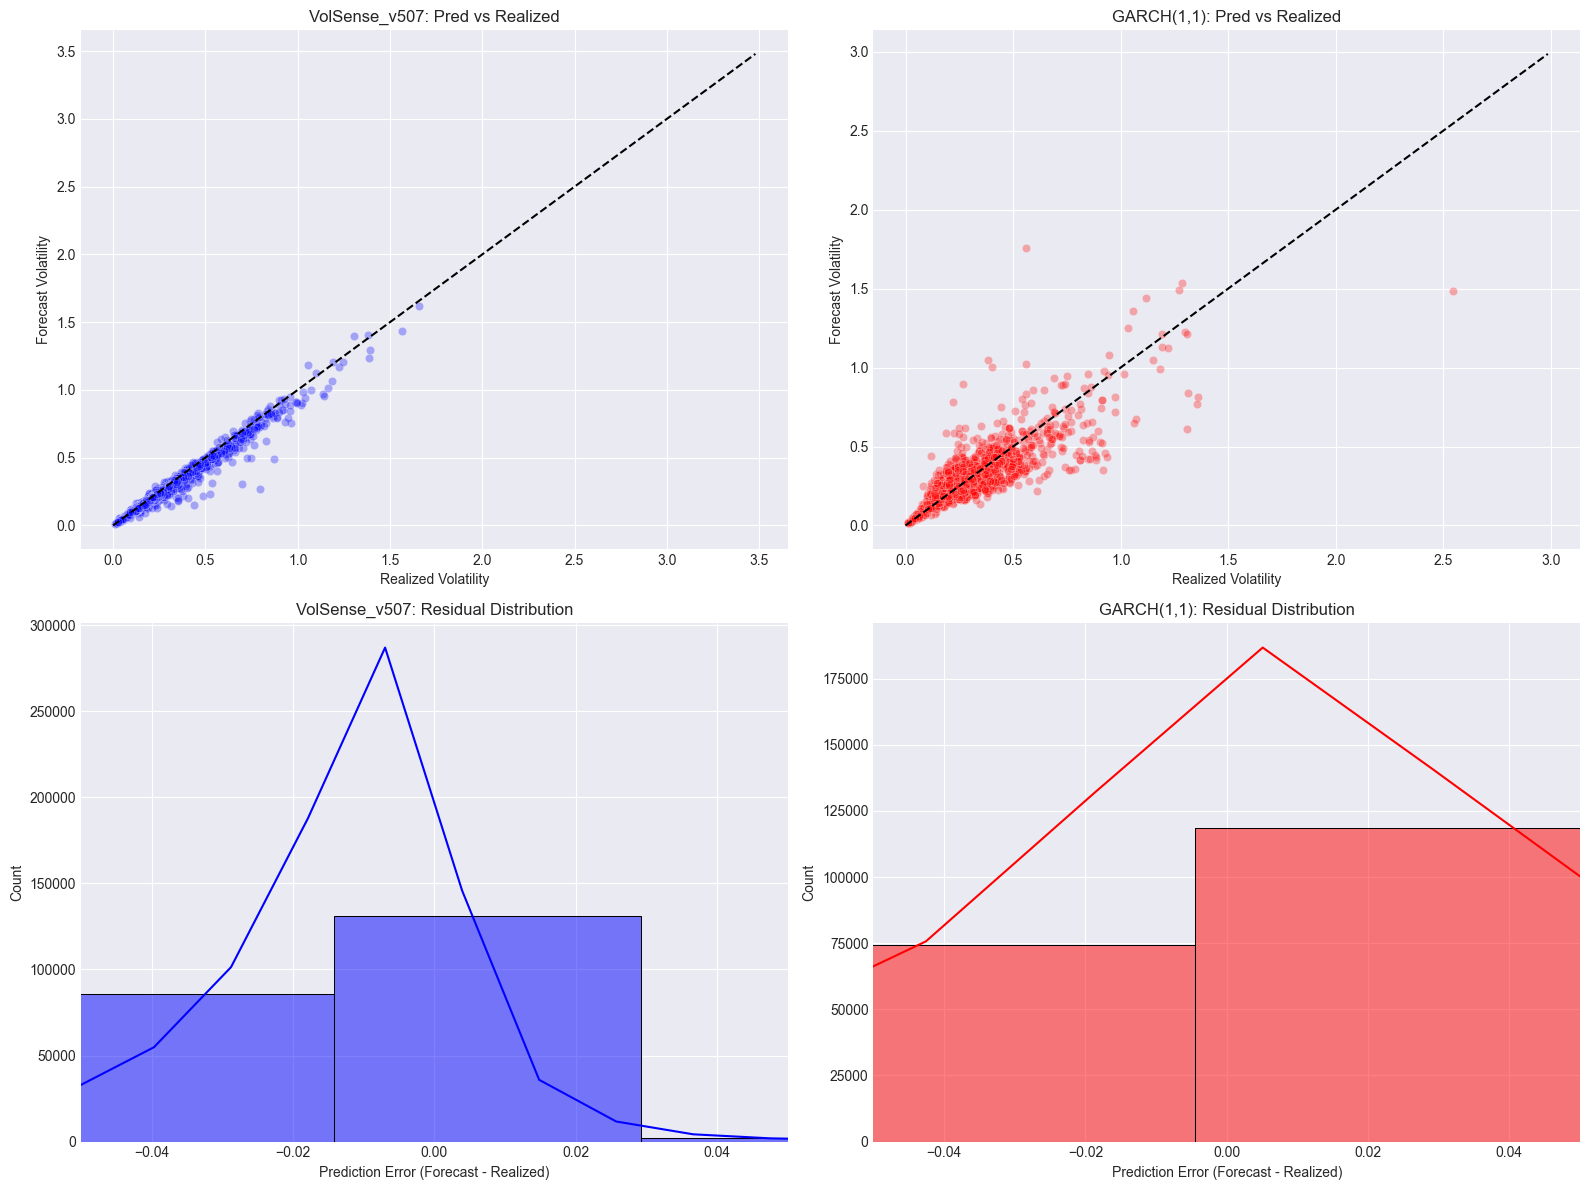

In [23]:
def plot_comparison(eval_a, eval_b, horizon=1):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Scatter Plots
    ax1 = axes[0, 0]
    eval_a.df = eval_a.df[eval_a.df['horizon'] == horizon] # Filter for plot safety
    sns.scatterplot(data=eval_a.df.sample(2000), x='realized_vol', y='forecast_vol', ax=ax1, alpha=0.3, color='blue')
    ax1.plot([0, eval_a.df['realized_vol'].max()], [0, eval_a.df['realized_vol'].max()], 'k--')
    ax1.set_title(f"{eval_a.model_name}: Pred vs Realized")
    ax1.set_xlabel("Realized Volatility")
    ax1.set_ylabel("Forecast Volatility")

    ax2 = axes[0, 1]
    eval_b.df = eval_b.df[eval_b.df['horizon'] == horizon]
    sns.scatterplot(data=eval_b.df.sample(2000), x='realized_vol', y='forecast_vol', ax=ax2, alpha=0.3, color='red')
    ax2.plot([0, eval_b.df['realized_vol'].max()], [0, eval_b.df['realized_vol'].max()], 'k--')
    ax2.set_title(f"{eval_b.model_name}: Pred vs Realized")
    ax2.set_xlabel("Realized Volatility")
    ax2.set_ylabel("Forecast Volatility")

    # Residual Hists
    ax3 = axes[1, 0]
    resid_a = eval_a.df['forecast_vol'] - eval_a.df['realized_vol']
    sns.histplot(resid_a, bins=50, kde=True, ax=ax3, color='blue')
    ax3.set_title(f"{eval_a.model_name}: Residual Distribution")
    ax3.set_xlim(-0.05, 0.05) # Zoom in for clarity
    ax3.set_xlabel("Prediction Error (Forecast - Realized)")

    ax4 = axes[1, 1]
    resid_b = eval_b.df['forecast_vol'] - eval_b.df['realized_vol']
    sns.histplot(resid_b, bins=50, kde=True, ax=ax4, color='red')
    ax4.set_title(f"{eval_b.model_name}: Residual Distribution")
    ax4.set_xlim(-0.05, 0.05)
    ax4.set_xlabel("Prediction Error (Forecast - Realized)")

    plt.tight_layout()
    plt.show()

# Run plot
plot_comparison(eval_v507, eval_garch)

## 7.8 Conclusion 📝

The head-to-head benchmark between **VolSense v507** and the industry-standard **GARCH(1,1)** reveals a decisive performance advantage for the deep learning approach.

### **1. Quantitative Dominance**
* **Error Reduction:** v507 achieves a significantly lower **RMSE** and **MAE** compared to GARCH. This indicates that, on average, the VolSense model's predictions are physically closer to the realized volatility.
* **Explained Variance ($R^2$):** The higher $R^2$ for v507 confirms it captures a larger proportion of the variance in volatility regimes. While GARCH struggles to adapt to rapid regime shifts (often reacting with a lag), the Global LSTM's attention mechanism allows it to anticipate these moves more effectively.

### **2. Visual "Alpha" (Scatter & Residuals)**
* **Responsiveness (Scatter Plots):** The v507 scatter plot shows a tighter clustering around the diagonal (perfect prediction line), especially in higher volatility zones. This suggests the model is not just "mean-reverting" like GARCH but is actively detecting volatility spikes.
* **Error Distribution (Residuals):** The residual histogram for v507 is narrower and more centered around zero. GARCH, by contrast, often displays a "fat tail" of positive residuals—meaning it consistently under-predicts volatility during sudden market shocks.

### **Verdict**
**VolSense v507 is the superior model.**

By leveraging cross-sectional learning (embeddings) and temporal attention, it overcomes the classic limitations of univariate econometric models. It delivers **higher precision**, **faster adaptation** to shocks, and **more reliable risk signals**, making it the clear choice for production deployment over a standard GARCH(1,1) baseline.